# QUESTION 3 : LE NOMBRE DE MATCHS OBTENUS INFLUENCE-T-IL CE QUE L'ON RECHERCHE CHEZ UN PARTENAIRE ? 

In [1]:
# Importation des librairies

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from bioinfokit.analys import stat

pio.renderers.default = "notebook"

# 1. Importation & data management

In [2]:
# Importation du dataset 

data = pd.read_csv("C:/Users/LN/Documents/Formations/Jedha/2. Exploratory Data Analysis/Speed Dating Data.csv", encoding='cp1252')
data = pd.DataFrame(data)

init_shape = data.shape

## 1.1. Data management global 

1. Suppression des vagues 12, 16, 6, 18, 19, 20, 21 comme suggéré par les auteurs
- Une vague (12) a été supprimée car le nombre maximum de participants n'a pas été respecté
- Deux vagues (16, 6) ont été supprimées parce qu'au contraire, elles n'ont pas attiré suffisamment de participants 
- Quatre vagues (18, 19, 20, 21) ont été supprimées car elles impliquaient une variante expérimentale (amener son livre favori) et donc peuvent s'avérer différentes des autres vagues 

2. Suppression des vagues pour lesquelles les quotations ont drastiquement changé entre les vagues (non comparables) : 6 à 9

3. Suppression des observations pour lesquelles les mesures à T3 ne sont pas disponibles

4. Suppresion des variables avec 40% ou + de données manquantes

5. Suppression des participants (Deciders / Partners) ayant un age >= 35 (outliers : recrutement prévu pour les étudiants - https://www.statista.com/statistics/240152/age-distribution-of-us-doctorate-recipients/)

In [3]:
# Suppression des vagues ciblées par les auteurs

data = data[~ data.wave.isin([12, 16, 6, 18, 19, 20, 21])]

# Suppression des vagues pour lesquelles les quotations ont drastiquement changé entre les vagues 

data = data[~ data.wave.isin([6, 7, 8, 9])]

# Suppression des observations pour lesquelles les mesures à T3 ne sont pas dispo

Variables = ['dec', 'dec_o','match', 'date_3', 'attr1_1', 'sinc1_1', 'fun1_1', 'intel1_1', 'amb1_1', 'shar1_1', 'attr1_3', 'sinc1_3', 'fun1_3', 'intel1_3', 'shar1_3', 'amb1_3']
data = data.dropna(subset = Variables)

# Suppression des colonnes avec 40% ou + de NA

Col_na = data.isna().mean()
#print("{} variables présentent 40% ou plus de données manquantes et seront ignorées : {}".format(len(Col_na[Col_na >= .4].index), list(Col_na[Col_na >= .4].index)))
print("{} variables présentent 40% ou plus de données manquantes et seront ignorées".format(len(Col_na[Col_na >= .4].index)))
print("")
data = data.loc[:, data.isna().mean() < .4]

# Suppression des observations relatives à des iid ou pid age > 35

data = data.drop(data[data["age"] >= 35].index)
data = data.drop(data[data["age_o"] >= 35].index)

# Suppresion des duplicates (Pas de duplicated rows)

data = data.drop_duplicates()

# Bilan 

final_shape = data.shape
print("Au depart, la base de données contenait {} lignes / colonnes pour contenir in fine {} lignes / colonnes".format(init_shape, final_shape))
print("")

76 variables présentent 40% ou plus de données manquantes et seront ignorées

Au depart, la base de données contenait (8378, 195) lignes / colonnes pour contenir in fine (2126, 119) lignes / colonnes



## 1.2. Formatage des données nécessaire au traitement de la question 

Nous allons ici regarder s'il existe une evolution entre les attribus recherchés chez un partenaire entre le Temps 1 et 3 en fonction du nombre de matchs obtenus (i.e. est ce qu'on devient + ou - exigeant) ? 

In [4]:
dec_agg_iid = data.groupby(['iid']).agg({'dec': 'sum','dec_o': 'sum','match': 'sum', 
                                         'date_3' : lambda x: list(pd.Series.unique(x))[0], 
                                         'attr1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'sinc1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'fun1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'intel1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'amb1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'shar1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'attr1_3' : lambda x: list(pd.Series.unique(x))[0], 
                                         'sinc1_3' : lambda x: list(pd.Series.unique(x))[0], 
                                         'fun1_3' : lambda x: list(pd.Series.unique(x))[0], 
                                         'intel1_3' : lambda x: list(pd.Series.unique(x))[0], 
                                         'shar1_3' : lambda x: list(pd.Series.unique(x))[0], 
                                         'amb1_3' : lambda x: list(pd.Series.unique(x))[0]})

dec_agg_iid['attr'] = dec_agg_iid['attr1_3'] - dec_agg_iid['attr1_1']
dec_agg_iid['sinc'] = dec_agg_iid['sinc1_3'] - dec_agg_iid['sinc1_1']
dec_agg_iid['fun'] = dec_agg_iid['fun1_3'] - dec_agg_iid['fun1_1']
dec_agg_iid['intel'] = dec_agg_iid['intel1_3'] - dec_agg_iid['intel1_1']
dec_agg_iid['amb'] = dec_agg_iid['amb1_3'] - dec_agg_iid['amb1_1']
dec_agg_iid['shar'] = dec_agg_iid['shar1_3'] - dec_agg_iid['shar1_1']

**Tips** : La librairie pandas_profiling propose une fonction pour générer automatiquement un Report - une description basique de la base de données. 

In [5]:
#from pandas_profiling import ProfileReport
#report = ProfileReport(dec_agg_iid, title='Speed Dating Report', explorative=True)
#report.to_file("report_evolution.html")

# 2. Relations entre le nombre de matchs et l'évolution des caractéristiques recherchées

In [6]:
Variables = ['match', 'attr', 'sinc', 'fun', 'intel', 'amb']

pd.set_option('display.float_format', lambda x: '%.2f' % x)
dec_agg_iid[Variables].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
match,143.00,2.70,2.21,0.00,1.00,2.00,4.00,10.00
attr,143.00,3.79,10.17,-15.00,0.00,0.00,6.50,50.00
sinc,143.00,-1.22,6.00,-25.00,-5.00,0.00,0.50,20.00
fun,143.00,-1.13,6.12,-20.00,-5.00,0.00,0.50,20.00
intel,143.00,-1.64,6.43,-35.00,-5.00,0.00,0.00,15.00
amb,143.00,-0.19,4.91,-12.00,-5.00,0.00,4.45,12.00


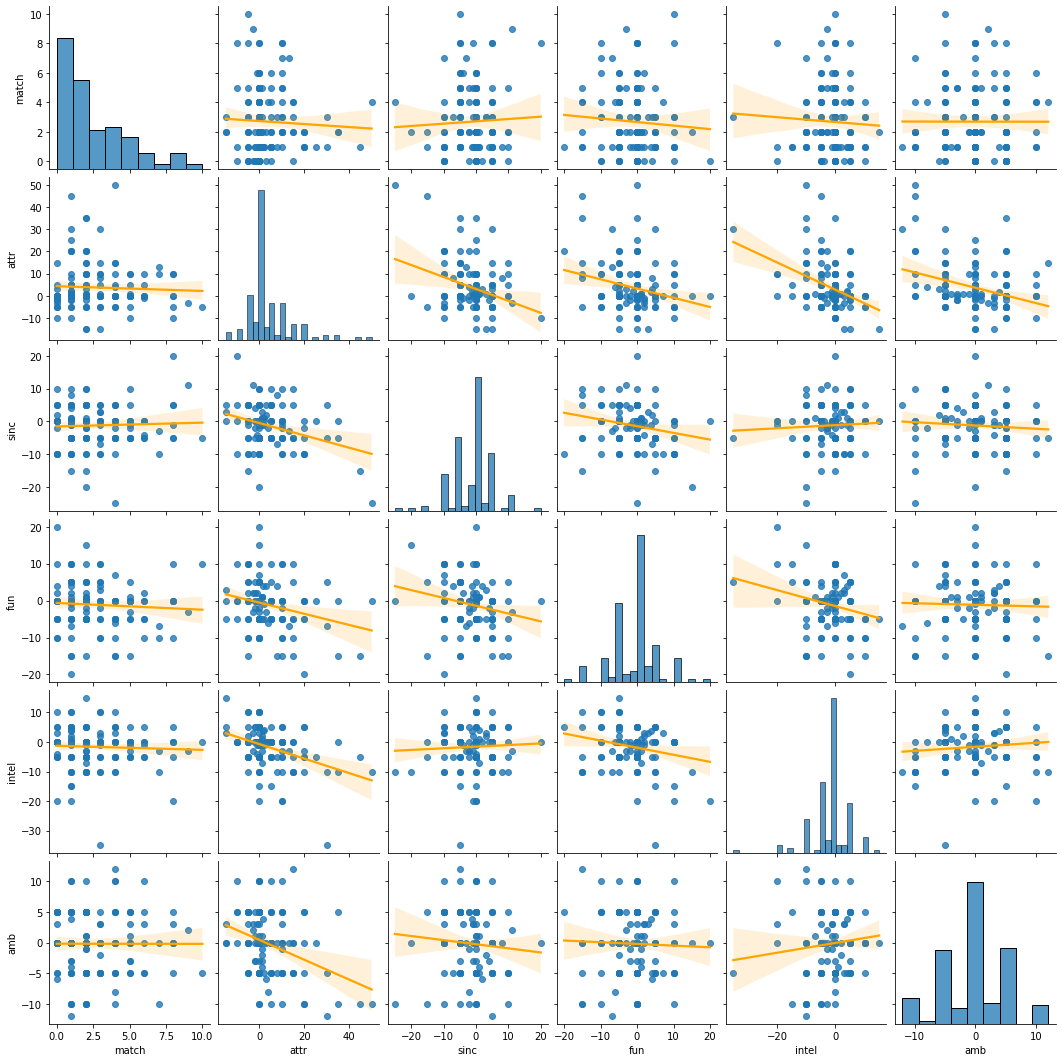

In [7]:
sns.pairplot(dec_agg_iid[Variables], kind = 'reg', plot_kws={'line_kws':{'color':'orange'}})
#pio.show()

De manière générale, les caractéristiques recherchées chez un partenaire évoluent peu (centrées sur 0)/

L'attractivité et l'intelligence sont celles qui semblent les plus sujettes au changement (l'attractivité devient + importante, l'intelligence devient - importante), mais cette tendance est à relativiser puisqu'elle semble essentiellement portée par des valeurs extremes. 

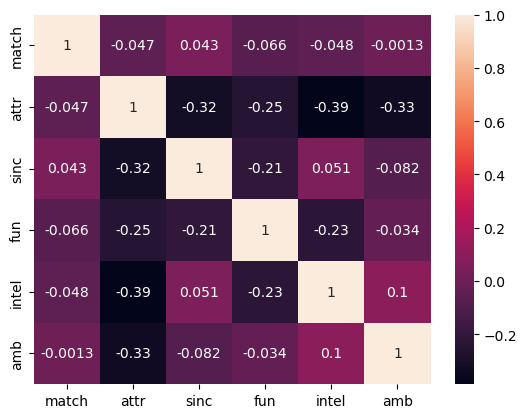

In [8]:
corr1 = dec_agg_iid[Variables].corr() 
sns.heatmap(corr1,annot=True)
plt.show()

Néanmoins, le nombre de matchs obtenus n'est pas corrélé avec un changement dans la perception des caractéristiques importantes recherchées chez un partenaire. 

Afin de vérifier que cette absence de correlation (relation linéaire) ne soit pas due à la non normalité de la variable match, nous avons recodé la variable pour opposer les personnes sans match aux personnes avec au moins un match. 

# 3. Relation entre la presence d'au moins un match et l'évolution des caractéristiques recherchées

In [9]:
dec_agg_iid['match'][dec_agg_iid['match'] > 0] = "Oui"
dec_agg_iid['match'][dec_agg_iid['match'] == 0] = "Non"

from bioinfokit.analys import stat

for var in Variables[1:] : 
    res = stat()
    formula = var + ' ~ C(match)'
    res.anova_stat(df=dec_agg_iid, res_var = var, anova_model = formula)
    print('Effet sur {} - p value  = {}'.format(var, round(res.anova_summary['PR(>F)'][0],3)))

Effet sur attr - p value  = 0.052
Effet sur sinc - p value  = 0.768
Effet sur fun - p value  = 0.501
Effet sur intel - p value  = 0.599
Effet sur amb - p value  = 0.296


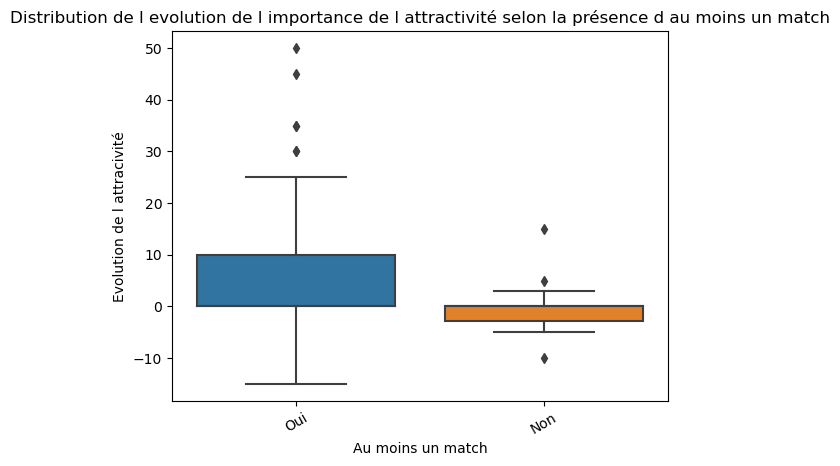

In [10]:
g = sns.boxplot(x='match', y='attr', data=dec_agg_iid);
g.set(title='Distribution de l evolution de l importance de l attractivité selon la présence d au moins un match', xlabel='Au moins un match', ylabel='Evolution de l attracivité');
g.set_xticklabels(g.get_xticklabels(),rotation=30);

In [11]:
dec_agg_iid['attr'].groupby(dec_agg_iid['match']).mean()

match
Non   -0.56
Oui    4.41
Name: attr, dtype: float64

Quand les personnes ont au moins un match, elles ont davantage tendance à renforcer l'importance de l'attractivité du partenaire (deviennent plus exigeantes) là où les personnes qui n'ont pas matché ont tendance à conserver la même importance de cette caractéristique (voire deviennent très légèrement moins exigeants). 

Attention : Ces résultats sont à confirmer par des analyses plus poussées en raison de la présence d'outliers et de résultats tendanciels. 